<a href="https://colab.research.google.com/github/karl-gardner/ml_code_reviews/blob/main/gb_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from IPython.display import Image
import graphviz
from graphviz import nohtml
import urllib.request

In [2]:
urllib.request.urlretrieve("https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt", "/diabetes.txt")
dataset = np.loadtxt("/diabetes.txt", skiprows=1)
X, y = dataset[:, :-1], dataset[:, -1]
X = (X-np.mean(X, axis=0))/(np.std(X, axis=0)*np.sqrt(X.shape[0]))

np.random.seed(12)
indices = np.random.permutation(X.shape[0])
training_idx, test_idx = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
X_train, X_test = X[training_idx], X[test_idx]
y_train, y_test = y[training_idx], y[test_idx]

In [3]:
class Node():
    def __init__(self, info, left=None, right=None):
        ''' constructor '''

        # save info for nodes that are instantiated
        self.info = info
        self.left = left
        self.right = right

In [4]:
class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, min_samples_leaf = 1, max_depth=3, min_impurity_decrease=0.0):
        """A decision tree regressor.

        min_samples_split : int or float, default=2
        The minimum number of samples required to split an internal node

        min_samples_leaf : int or float, default=1
        The minimum number of samples required to be at a leaf node.
        A split point at any depth will only be considered if it leaves at
        least ``min_samples_leaf`` training samples in each of the left and
        right branches.  This may have the effect of smoothing the model,
        especially in regression.

        max_depth : int, default=3
        The maximum depth of the tree, where index starts at 0 for the root node. For a tree consisting
        of just a root node put max_depth=0

        min_impurity_decrease : float, default=0.0
        A node will be split if this split induces a decrease of the impurity
        greater than or equal to this value.

        The weighted impurity decrease equation is the following::

            N_t / N * (impurity - N_t_R / N_t * right_impurity
                                - N_t_L / N_t * left_impurity)

        where ``N`` is the total number of samples, ``N_t`` is the number of
        samples at the current node, ``N_t_L`` is the number of samples in the
        left child, and ``N_t_R`` is the number of samples in the right child.
        """

        # initialize the root of the tree and graphviz instance for a directed graph
        self.root = None
        self.g = graphviz.Digraph('g', filename='btree.gv',
                     node_attr={'shape': 'record', 'height': '.1'}, format="png")

        # stopping conditions for the regression tree
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.min_impurity_decrease = min_impurity_decrease

    def build_tree(self, X, Y, cur_depth=0):
        ''' recursive function to build the tree '''
        best_split = {}
        # split until stopping conditions are not met
        if X.shape[0]>=self.min_samples_split and cur_depth<self.max_depth:
            # find the best split
            best_split = self.get_best_split(X, Y)
            # check if impurity decrease is higher than the min_impurity_decrease
            if best_split["imp_dec"]>=self.min_impurity_decrease:
                # split dataset into left and right constituents
                left_index = X[:, best_split["feature_index"]] <= best_split["threshold"]
                right_index = X[:, best_split["feature_index"]] > best_split["threshold"]
                X_left, Y_left = X[left_index], Y[left_index]
                X_right, Y_right = X[right_index], Y[right_index]
                # recur left
                left_subtree = self.build_tree(X_left, Y_left, cur_depth+1)
                # recur right
                right_subtree = self.build_tree(X_right, Y_right, cur_depth+1)
                # return decision node
                return Node(best_split, left_subtree, right_subtree)

        # compute leaf node and add to dictionary
        best_split["values"] = Y
        # return leaf node
        return Node(best_split)

    def get_best_split(self, X, Y):
        ''' function to find the best split '''

        # dictionary to store the best split
        best_split = {"imp_dec": -1}
        # loop over all the features
        for feature_index in range(X.shape[1]):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                # Split target array into two parts
                Y_left = Y[X[:, feature_index] <= threshold]
                Y_right = Y[X[:, feature_index] > threshold]
                # check if childs are greater than min_samples_leaf
                if len(Y_left)>=self.min_samples_leaf and len(Y_right)>=self.min_samples_leaf:
                    # compute information gain (impurity decrease)
                    N_t, N_t_L, N_t_R = len(Y), len(Y_left), len(Y_right)
                    imp_dec = N_t/self.N*(np.var(Y)-N_t_L/N_t*np.var(Y_left)-N_t_R/N_t*np.var(Y_right))
                    # if impurity decrease (variance reduction) > best_split["imp_dec"] then update it:
                    if imp_dec > best_split["imp_dec"]:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["imp_dec"] = imp_dec

        # return best split
        return best_split

    def fit(self, X, Y):
        self.N = len(Y)
        self.root = self.build_tree(X,Y)

    def make_prediction(self, x, tree, i = 0):
        ''' function to predict new dataset '''
        if "values" in tree.info:

            return (tree.info["values"].mean(), i)
        feature_val = x[tree.info["feature_index"]]
        if feature_val<=tree.info["threshold"]:
            return self.make_prediction(x, tree.left, 2*i+1)
        else:
            return self.make_prediction(x, tree.right, 2*i+2)

    def predict(self, X):
        ''' function to predict a single data point '''
        preditions = [self.make_prediction(x, self.root)[0] for x in X]
        return preditions

    def apply(self, X):
        index = [self.make_prediction(x, self.root)[1] for x in X]
        return np.array(index)

    def save_tree(self, tree = None, i = 0, filename = "decision_tree"):
        if tree:
            # global count
            # tree, count = self.root, 0
            # tree.id = 0
            if "values" in tree.info:
                self.g.node(f"node{i}", nohtml(
                    f"<f0> |<f1> {tree.info['values'].mean():.3f}|<f2>"))
            else:
                self.g.node(f"node{i}", nohtml(
                    f"<f0> |<f1> x[{tree.info['feature_index']}]≤{tree.info['threshold']:.3f}|<f2>"))

            if i > 0:
                self.g.edge(f"node{int((i-1)/2)}:{'f2' if i%2==0 else 'f0'}", f"node{i}:f1")
            self.save_tree(tree.left, 2*i+1)
            self.save_tree(tree.right, 2*i+2)

        if i == 0:
          self.g.render(filename)

In [5]:
# reg = DecisionTreeRegressor(max_depth=3)
# # Fit the model
# reg.fit(X_train, y_train)
# reg.save_tree(reg.root)
# Image("decision_tree.png")

# y_pred = reg.predict(X_test)
# print("mse: ", np.mean(np.square(y_pred-y_test)))

In [6]:
# from sklearn.tree import DecisionTreeRegressor as DecisionTreeRegressor_skl
# from sklearn.tree import export_graphviz
# reg = DecisionTreeRegressor_skl(max_depth=3)
# reg.fit(X_train, y_train)
# from six import StringIO
# with open("/houses.dot", 'w') as f:
#   f = export_graphviz(reg, out_file=f)


# # # run the Graphviz dot command to convert the .dot file to .png
# !dot -Tpng /houses.dot -o /houses.png

# Image("/houses.png")
# # y_pred = reg.predict(X_test)
# # np.mean(np.square(y_pred-y_test))

In [7]:
class GradientBoostingRegressor:
    # Initialize the object entity
    # Need at least 1 tree
    def __init__(self, learning_rate=0.1, min_samples_leaf=1, max_depth=3, n_estimators=10):

        # Store the input parameters of the class
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.n_estimators = n_estimators

    def fit(self, X, y):

        # Initialize a list to store tree objects
        self.trees = [DecisionTreeRegressor(max_depth=0, min_samples_leaf=self.min_samples_leaf)]
        self.trees[0].fit(X,y)

        for i in range(self.n_estimators-1):
            # Initialize single tree object
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf)

            # Fit the tree using the residuals calculated from the combination of all the previous trees
            tree.fit(X, y - self.predict(X))

            # Append tree to a list
            self.trees.append(tree)

    def predict(self, X):

        # Initialize a list to store the prediction value for each tree
        trees_predictions = np.empty((len(X), len(self.trees)))

        # Iterate over all trees and populate the trees_predictions array
        for i, tree in enumerate(self.trees):
            trees_predictions[:, i] = tree.predict(X)

        # Take the sum of predictions from all trees for each observation in dataset
        predictions = trees_predictions[:, 0] + np.sum(self.learning_rate*trees_predictions[:, 1:], axis=1)

        # Return an array with predictions for each observation
        return predictions

In [8]:
reg = GradientBoostingRegressor(n_estimators=20, max_depth=3)
# Fit the model
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f"mse: {np.mean(np.square(y_test-y_pred))}")

mse: 2721.811035361836


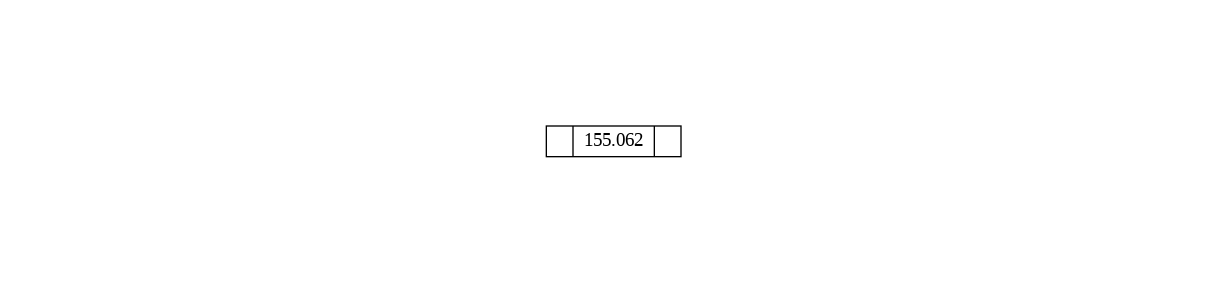

In [9]:
import imageio.v2 as imageio
import cv2

for i in range(5):
  reg.trees[i].save_tree(reg.trees[i].root, filename=f"decision_tree_{i}")

im_1 = cv2.imread("decision_tree_0.png")
im_2 = cv2.imread("decision_tree_1.png")


h_pad = int((im_2.shape[0]-im_1.shape[0])/2)
w_pad = int((im_2.shape[1]-im_1.shape[1])/2)
im_1 = cv2.copyMakeBorder(im_1, h_pad, h_pad, w_pad, w_pad+1, cv2.BORDER_REPLICATE)
cv2.imwrite("decision_tree_0.png", im_1)
cv2.imwrite("decision_tree_1.png", im_2)
cv2.imwrite("decision_tree_2.png", cv2.resize(cv2.imread("decision_tree_2.png"), (im_2.shape[1], im_2.shape[0])))
cv2.imwrite("decision_tree_3.png", cv2.resize(cv2.imread("decision_tree_3.png"), (im_2.shape[1], im_2.shape[0])))
cv2.imwrite("decision_tree_4.png", cv2.resize(cv2.imread("decision_tree_4.png"), (im_2.shape[1], im_2.shape[0])))


images = []
for i in range(5):
  images.append(imageio.imread(f"decision_tree_{i}.png"))

imageio.mimwrite('decision_trees.gif', images, loop = 10, duration = 1000)
Image(open('decision_trees.gif','rb').read())